In [ ]:
project = "lcvae"

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import nn, optim
torch.manual_seed(3409)

In [ ]:
import numpy as np
np.random.seed(0)
import pandas as pd
from pandas.core.frame import DataFrame

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/20221108')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_balanced = pd.read_csv("/content/drive/MyDrive/20221108/dataset/train_balanced.csv")
train_dataset = train_balanced

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

# Train

In [ ]:
import databuild
traindata = databuild.DataBuilder(train_dataset)
trainloader = databuild.DataLoader(dataset = traindata, batch_size = 73)

## Build Model

In [ ]:
class Autoencoder(nn.Module):
  
    def __init__(self, D_in, H1, H2, H3, latent_dim): 
      
        super(Autoencoder,self).__init__()
        
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)
        
        self.encoder = nn.Sequential(
                nn.Linear(D_in, H1), nn.BatchNorm1d(H1), nn.ReLU(),
                nn.Linear(H1, H2),  nn.BatchNorm1d(H2), nn.ReLU(),
                nn.Linear(H2, H3),  nn.BatchNorm1d(H3), nn.ReLU(), 
                nn.Linear(H3, latent_dim), nn.BatchNorm1d(latent_dim), nn.ReLU(),
                nn.Linear(latent_dim, latent_dim), nn.BatchNorm1d(latent_dim), nn.ReLU(),
                ) 

        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, latent_dim), nn.BatchNorm1d(latent_dim), nn.ReLU(), 
                nn.Linear(latent_dim, H3), nn.BatchNorm1d(H3), nn.ReLU(), 
                nn.Linear(H3, H2),  nn.BatchNorm1d(H2),  nn.ReLU(), 
                nn.Linear(H2, H1),  nn.BatchNorm1d(H1),  nn.ReLU(), 
                nn.Linear(H1, D_in), nn.BatchNorm1d(D_in), nn.ReLU(),
                )
        
        self.classifier = nn.Sequential(
                nn.Linear(D_in, D_in), nn.ReLU(),
                nn.Linear(D_in, D_in), nn.ReLU(),
                nn.Linear(D_in, 2),   nn.Sigmoid(),
                )
    

    def forward(self, x): 
        latent_fea = self.encoder(x)
        mu, logvar = self.compute_r1_r2(latent_fea)
        z = self.reparameterize(mu, logvar)
        latent_label = self.classifier(z) 
        generated_data = self.decoder(z)
        return  mu, logvar, latent_fea, z, generated_data, latent_label
        # x (encoder) latent_fea
        # latent_fea (fit) z, latent_label
        # z (decoder) generated data, output_label
      
    def compute_r1_r2(self, latent_fea):
        r1 = self.fc21(latent_fea)
        r2 = self.fc22(latent_fea)
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
D_in = traindata.x.shape[1]-1
H1 = 4
H2 = 4
H3 = 4
latent_dim = 4
model = Autoencoder(D_in, H1, H2, H3, latent_dim)

In [ ]:
model = model.to(device)

In [ ]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=1e-4, last_epoch=-1, verbose=False)

## Train Model

In [ ]:
train_losses_MSE = []
train_losses_KLD = []
classifier_losses = []

In [ ]:
celoss = nn.CrossEntropyLoss()
reconst_loss = nn.MSELoss()

def clip_gradient(grad_clip):
  for group in optimizer.param_groups:
    for param in group['params']:
      if param.grad is not None:
        param.grad.data.clamp_(-grad_clip, grad_clip)

def train(epoch):
    loss_plot = []

    model.train()
    train_loss_MSE = 0
    train_loss_KLD = 0
    classifier_loss = 0

    for batch_idx, data in enumerate(trainloader): 
      
      data = data.float().to(device)
      ground_truth, ground_label = data[:, 0:-1], data[:,-1]
      ground_label = ground_label.long()
      optimizer.zero_grad()
      mu, logvar, latent_fea, z, generated_data, latent_label = model(ground_truth)
      loss_MSE = reconst_loss(generated_data, ground_truth)
      loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      classifier_loss = celoss(latent_label, ground_label)

      if epoch < 500:
        loss = loss_MSE + 0*loss_KLD + 100*classifier_loss
      elif epoch <1000:
        loss = loss_MSE + 0.001*loss_KLD + 100*classifier_loss
      elif epoch < 2000: 
        loss = 5*loss_MSE + 0.005*loss_KLD + 250*classifier_loss
      else: 
        loss = 10*loss_MSE + 0.01*loss_KLD + 500*classifier_loss

      loss.backward()
      
      train_loss_MSE += loss_MSE.item()
      train_loss_KLD += loss_KLD.item()
      classifier_loss += classifier_loss.item()

      clip_gradient(0.5)
      optimizer.step()

    if epoch % 100 == 0:        
        print(  'Epoch:{}   Average training MSE loss: {:.4f}'.format(
                    epoch, train_loss_MSE / len(trainloader.dataset)),
                'Average training KLD loss: {:.4f}'.format(
                    train_loss_KLD / len(trainloader.dataset)),
                'Average classifier1 loss: {:.4f}'.format(
                    classifier_loss  / len(trainloader.dataset)),
          )
        
    if epoch % 1 == 0:        
        train_losses_MSE.append(train_loss_MSE / len(trainloader.dataset))
        train_losses_KLD.append(train_loss_KLD / len(trainloader.dataset))
        classifier_losses.append(classifier_loss / len(trainloader.dataset))

In [ ]:
epochs = 5000
log_interval = 10

for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()

Epoch:100   Average training MSE loss: 0.0012 Average training KLD loss: 3.9224 Average classifier1 loss: 0.0030
Epoch:200   Average training MSE loss: 0.0009 Average training KLD loss: 6.8615 Average classifier1 loss: 0.0029
Epoch:300   Average training MSE loss: 0.0008 Average training KLD loss: 9.6004 Average classifier1 loss: 0.0028
Epoch:400   Average training MSE loss: 0.0007 Average training KLD loss: 10.2477 Average classifier1 loss: 0.0027
Epoch:500   Average training MSE loss: 0.0006 Average training KLD loss: 13.2181 Average classifier1 loss: 0.0026
Epoch:600   Average training MSE loss: 0.0006 Average training KLD loss: 10.9249 Average classifier1 loss: 0.0025
Epoch:700   Average training MSE loss: 0.0005 Average training KLD loss: 10.9312 Average classifier1 loss: 0.0025
Epoch:800   Average training MSE loss: 0.0005 Average training KLD loss: 10.7288 Average classifier1 loss: 0.0025
Epoch:900   Average training MSE loss: 0.0005 Average training KLD loss: 11.6087 Average cl

In [ ]:
classifier_losses_tensor = torch.tensor(classifier_losses, requires_grad=True)
classifier_losses_numpy = classifier_losses_tensor.detach().numpy()

df = pd.DataFrame([train_losses_MSE,
                   train_losses_KLD, 
                   classifier_losses_numpy])
df = df.transpose()
df.columns=['LCVAE MSE',
            'LCVAE KLD',
            'LCVAE Classifier']

In [ ]:
# save loss
save_loss_path = f"/content/drive/MyDrive/20221108/saved_model/{project}_loss.csv"
df.to_csv(save_loss_path, index=False)
# load loss
df = pd.read_csv(save_loss_path)

In [ ]:
sns.set_theme(style='white')
sns.set_palette("muted")

<Figure size 432x288 with 0 Axes>

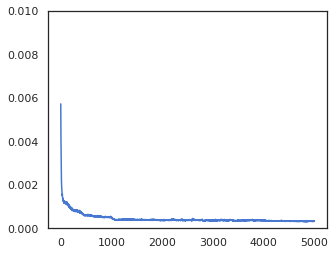

In [ ]:
plt.figure()
f, ax = plt.subplots(figsize = [5,4])
x = df.iloc[:,[0]].to_numpy()
plt.plot(x)
ax.set_ylim([0, 0.01])
plt.show()

<Figure size 432x288 with 0 Axes>

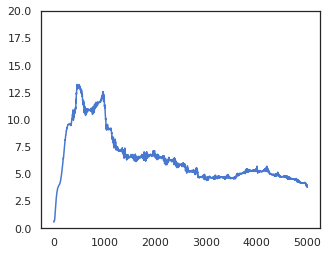

In [ ]:
plt.figure()
f, ax = plt.subplots(figsize = [5,4])
x = df.iloc[:,[1]].to_numpy()
plt.plot(x)
ax.set_ylim([0, 20])
plt.show()

<Figure size 432x288 with 0 Axes>

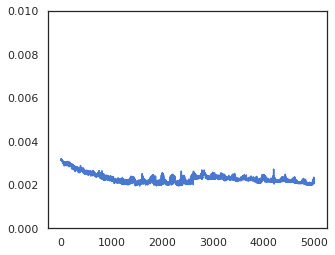

In [ ]:
plt.figure()
f, ax = plt.subplots(figsize = [5,4])
x = df.iloc[:,[2]].to_numpy()
plt.plot(x)
ax.set_ylim([0, 0.01])
plt.show()

# save model

In [ ]:
# save model
save_model_path = f"/content/drive/MyDrive/20221108/saved_model/{project}.pth"
torch.save(model.state_dict(), save_model_path)

In [ ]:
# check
model = Autoencoder(D_in, H1, H2, H3, latent_dim)
model.load_state_dict(torch.load(save_model_path, map_location='cpu'))

<All keys matched successfully>